# Nhận diện gương mặt với khẩu trang

# 1. Sơ lược dự án

Một trong những ứng dụng phổ biến của Máy học là **Nhận diện gương mặt**. Ứng dụng này có mặt hầu như ở mọi mặt trong đời sống xã hội cũng như khoa học công nghệ, chúng ta sử dụng nhận diện gương mặt để chấm công nhân viên, sử dụng nhận diện gương mặt cho mục đích an ninh, ... Ở dự án này, chúng ta cũng sẽ tiến hành tạo ra một mô hình nâng cao hơn. Vẫn là mô hình **nhận diện gương mặt**, nhưng lần này chúng ta sẽ tiến hành thêm một bước sau khi đã nhận diện được một gương mặt từ tấm ảnh hay video, đó là xem thử liệu một khuôn mặt **có đeo khẩu trang hay không**. Việc này có ứng dụng rất lớn trong bối cảnh dịch bệnh Covid hiện nay, tiến hành phát hiện sớm một người không đeo khẩu trang có thể giảm thiểu mức độ lây nhiễm xuống thấp, qua đó góp phần thúc đẩy việc đẩy lùi dịch bệnh một cách nhanh chóng và ít tốn kém hơn. Tức là mô hình của chúng ta sẽ hoạt động như sau:

**Ảnh chứa gương mặt (1) --> nhận diện gương mặt (2) --> nhận diện có đeo khẩu trăng hoặc không (3) --> Gán nhãn tương ứng (4)**

Chúng ta sẽ tạo ra mô hình ở **bước (3)** và sử dụng các mô hình nhận diện gương mặt có sẵn để tạo thành một pipeline hoàn chỉnh ở trên

Cụ thể, trong dự án này chúng ta sẽ thực hiện các bước sau:

1. Tạo ra một tập dữ liệu (bao gồm các gương mặt có và không có đeo khẩu trang) từ nhiều nguồn khác nhau.
2. Tiền xử lý dữ liệu
3. Chia tập dữ liệu dùng riêng cho mục đích huấn luyện và kiểm tra mô hình
4. Huấn luyện mô hình
5. Kiểm tra mô hình
6. Cải tiến

- Vẫn như các dự án máy học khác, điều đầu tiên chúng ta cần làm là import các thư viện cần thiết

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
from imutils import paths

import tensorflow as tf

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.efficientnet import preprocess_input

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [3]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

In [4]:
# Get helper_functions.py script from course GitHub
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import helper functions we're going to use
from helper_functions import create_tensorboard_callback, unzip_data

--2024-04-15 15:07:27--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-04-15 15:07:27 (31.6 MB/s) - ‘helper_functions.py’ saved [10246/10246]



# 2. Khởi tạo tập dữ liệu

Lần này, dữ liệu sẽ không được cung cấp sẵn, bạn sẽ phải tự tạo ra một tập dữ liệu từ nhiều nguồn có sẵn và ghép chúng lại thành một tập dữ liệu duy nhất cho dự án này.

1. Đầu tiên, bạn phải download các tập dữ liệu từ các nguồn sau đây

    - https://www.kaggle.com/andrewmvd/face-mask-detection
	- https://www.kaggle.com/omkargurav/face-mask-dataset
	- https://www.kaggle.com/prithwirajmitra/covid-face-mask-detection-dataset
	- https://www.kaggle.com/vijaykumar1799/face-mask-detection
	- https://www.kaggle.com/ashishjangra27/face-mask-12k-images-dataset
	- https://www.kaggle.com/spandanpatnaik09/face-mask-detectormask-not-mask-incorrect-mask
	- https://www.kaggle.com/sumansid/facemask-dataset
	- https://drive.google.com/file/d/1m6Rd5nxol_cT2EKHSodli9HD1L6k0bKR/view
    
Bạn có thể thấy, các tập dữ liệu đã được chia nhỏ thành 2 thư mục riêng biệt, đó là **có đeo khẩu trang (with mask)** và **không đeo khẩu trang (without mask)**. Chúng có thể được chứa trong các thư mục lớn hơn nữa là train, validation và test; nhưng điều này không đáng kể, bạn chỉ cần lưu ý 2 thư mục đã nêu ở trên.

2. Bạn đem các ảnh tải được bỏ vào trong thư mục **dataset** theo cấu trúc sau:

```
dataset <- thư mục chứa ảnh dữ liệu cho dự án
└───with mask <- ảnh của các khuôn mặt có đeo khẩu trang được chứa trong thư mục này
│       1.jpg
│       ...
└───without mask <- ảnh của các khuôn mặt không có đeo khẩu trang được chứa trong thư mục này
│       2.jpg
│       ...         
```

**Lưu ý:** Có thể sẽ có một vài tấm ảnh bị trùng giữa các nguồn dữ liệu khác nhau, bạn chỉ cần bỏ qua quá trình sao chép các tấm ảnh bị trùng này vào tập **dataset** là được.

**Unzip File**

In [5]:
# Unzip the collecting dataset from zip file in Google Drive
unzip_data("/content/drive/MyDrive/Data Sciene Funix/306/Assignment/ASM1/dataset/dataset.zip")

**Check image extension**

In [6]:
def check_image_extensions(folder_path):
    # Define image extension list
    image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp', '.svg', '.tif', '.tiff']

    # Get list of image files in the folder
    image_files = [file for file in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, file))]

    # Filter image files based on extension. Using set() to ensure no duplicated values exist
    image_extensions_found = set()

    # Loop through each image and extract image extension
    for file in image_files:
        _, extension = os.path.splitext(file)
        if extension.lower() in image_extensions:
            image_extensions_found.add(extension.lower())

    return image_extensions_found

In [7]:
# Image extension in 'with mask' folder
folder_path = '/content/final_dataset/with mask'
image_extensions_found = check_image_extensions(folder_path)

print("Image extensions found in the folder:", image_extensions_found)

Image extensions found in the folder: {'.jpg', '.jpeg', '.gif', '.png'}


In [8]:
# Image extension in 'without mask' folder
folder_path = '/content/final_dataset/without mask'
image_extensions_found = check_image_extensions(folder_path)

print("Image extensions found in the folder:", image_extensions_found)

Image extensions found in the folder: {'.jpg', '.jpeg', '.gif', '.png'}


**Preprocessing Function to find and remove duplicated image**

In [9]:
# Importing Lib
import hashlib

Function checking duplicated images

In [10]:
def find_duplicate_images(folder_path):
    # Define a dictionary to store image hashes (unique identifiers)
    image_hashes = {}

    # Define a list to store pairs of duplicated images
    duplicate_pairs = []

    # Loop through each image in the folder
    for filename in os.listdir(folder_path):
        # Check if the file is an image with these extension
        if filename.lower().endswith(('.jpg', '.png', '.jpeg', '.gif')):
            # Get the full path of the image
            image_path = os.path.join(folder_path, filename)

            # Open the image file and read its content
            with open(image_path, 'rb') as f:
                image_content = f.read()
                # Calculate the MD5 hash of the image content
                image_hash = hashlib.md5(image_content).hexdigest()

            # Check if the image content is existing in image_hashes
            # If two images are identical, their MD5 hashes will be the same.
            # If yes, means the image is a duplicated image
            if image_hash in image_hashes:
                # Get the first image that has duplicated
                first_image = image_hashes[image_hash]

                # Append the pair of duplicated images
                duplicate_pairs.append((first_image, filename))
            else:
                # If not, add the image to image_hashes
                image_hashes[image_hash] = filename
    return duplicate_pairs

Function check and remove duplicate image

In [11]:
def find_and_remove_duplicate_images(folder_path):
    image_hashes = {}
    duplicate_images = []

    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.jpg', '.png', '.jpeg', '.gif')):
            image_path = os.path.join(folder_path, filename)
            with open(image_path, 'rb') as f:
                image_content = f.read()
                image_hash = hashlib.md5(image_content).hexdigest()

            if image_hash in image_hashes:
                duplicate_images.append(filename)
            else:
                image_hashes[image_hash] = filename

    # Remove duplicate images
    for duplicate_img in duplicate_images:
        duplicate_path = os.path.join(folder_path, duplicate_img)
        os.remove(duplicate_path)
        print(f"Removed duplicate image: {duplicate_img}")

**Preprocessing with folder 'with mask'**

Applying function

In [12]:
folder_path_with_mask = "/content/final_dataset/with mask"
duplicate_pairs = find_duplicate_images(folder_path_with_mask)

if duplicate_pairs:
    print(f"Duplicated image pairs found in {folder_path_with_mask}:")
    for first_img, duplicate_img in duplicate_pairs:
        print(f"{first_img} - {duplicate_img}")
else:
    print(f"No duplicated images found in {folder_path_with_mask}.")

Duplicated image pairs found in /content/final_dataset/with mask:
110-with-mask.jpg - with_mask_885.jpg
123.png - 181.png
with_mask_1660.jpg - 455-with-mask.jpg
with_mask_1318.jpg - 240-with-mask.jpg
with_mask_994.jpg - 163-with-mask.jpg
with_mask_1605.jpg - 404-with-mask.jpg
299-with-mask.jpg - with_mask_1429.jpg
2018.png - 1809.png
259-with-mask.jpg - with_mask_1351.jpg
1175.png - 111.png
2440.png - 2733.png
895.png - 1406.png
130.png - 855.png
345-with-mask.jpg - with_mask_1533.jpg
with_mask_1911.jpg - with_mask_1899.jpg
304.png - 962.png
with_mask_1689.jpg - 49-with-mask.jpg
with_mask_1170.jpg - with_mask_1177.jpg
218-with-mask.jpg - with_mask_1271.jpg
103-with-mask.jpg - with_mask_869.jpg
5.png - 1079.png
623.png - 2195.png
1005.png - 1513.png
420-with-mask.jpg - with_mask_1623.jpg
with_mask_1740.jpg - 75-with-mask.jpg
490.png - 1301.png
1075.png - 95.png
262-with-mask.jpg - with_mask_1359.jpg
with_mask_1943.jpg - with_mask_1942.jpg
with_mask_1714.jpg - with_mask_2441.jpg
289-with

In [13]:
find_and_remove_duplicate_images(folder_path_with_mask)

Removed duplicate image: with_mask_885.jpg
Removed duplicate image: 181.png
Removed duplicate image: 455-with-mask.jpg
Removed duplicate image: 240-with-mask.jpg
Removed duplicate image: 163-with-mask.jpg
Removed duplicate image: 404-with-mask.jpg
Removed duplicate image: with_mask_1429.jpg
Removed duplicate image: 1809.png
Removed duplicate image: with_mask_1351.jpg
Removed duplicate image: 111.png
Removed duplicate image: 2733.png
Removed duplicate image: 1406.png
Removed duplicate image: 855.png
Removed duplicate image: with_mask_1533.jpg
Removed duplicate image: with_mask_1899.jpg
Removed duplicate image: 962.png
Removed duplicate image: 49-with-mask.jpg
Removed duplicate image: with_mask_1177.jpg
Removed duplicate image: with_mask_1271.jpg
Removed duplicate image: with_mask_869.jpg
Removed duplicate image: 1079.png
Removed duplicate image: 2195.png
Removed duplicate image: 1513.png
Removed duplicate image: with_mask_1623.jpg
Removed duplicate image: 75-with-mask.jpg
Removed duplic

Re-check whether the duplicate images are removed or not

In [14]:
duplicate_pairs = find_duplicate_images(folder_path_with_mask)

if duplicate_pairs:
    print(f"Duplicated image pairs found in {folder_path_with_mask}:")
    for first_img, duplicate_img in duplicate_pairs:
        print(f"{first_img} - {duplicate_img}")
else:
    print(f"No duplicated images found in {folder_path_with_mask}.")

No duplicated images found in /content/final_dataset/with mask.


**Preprocessing with folder 'without mask'**

Applying function

In [15]:
folder_path_without_mask = "/content/final_dataset/without mask"
duplicate_pairs = find_duplicate_images(folder_path_without_mask)

if duplicate_pairs:
    print(f"Duplicated image pairs found in {folder_path_without_mask}:")
    for first_img, duplicate_img in duplicate_pairs:
        print(f"{first_img} - {duplicate_img}")
else:
    print(f"No duplicated images found in {folder_path_without_mask}.")

Duplicated image pairs found in /content/final_dataset/without mask:
without_mask_1334.jpg - without_mask_1264.jpg
468.jpg - without_mask_963.jpg
without_mask_889.jpg - 415.jpg
389.jpg - without_mask_851.jpg
without_mask_665.jpg - 253.jpg
without_mask_1334.jpg - without_mask_1333.jpg
211.jpg - without_mask_608.jpg
without_mask_3387.jpg - without_mask_1129.jpg
without_mask_3453.jpg - without_mask_3455.jpg
18.jpg - without_mask_3659.jpg
410.jpg - without_mask_883.jpg
without_mask_628.jpg - 226.jpg
285.jpg - without_mask_707.jpg
without_mask_3612.jpg - 149.jpg
without_mask_3518.jpg - 105.jpg
131.jpg - without_mask_3583.jpg
328.jpg - without_mask_777.jpg
without_mask_659.jpg - 249.jpg
without_mask_1277.jpg - without_mask_1276.jpg
without_mask_1421.jpg - without_mask_1423.jpg
391.jpg - without_mask_856.jpg
without_mask_1042.jpg - 69.jpg
without_mask_893.jpg - 417.jpg
365.jpg - without_mask_826.jpg
74.jpg - without_mask_1058.jpg
without_mask_1038.jpg - 67.jpg
230.jpg - without_mask_636.jpg
w

In [16]:
find_and_remove_duplicate_images(folder_path_without_mask)

Removed duplicate image: without_mask_1264.jpg
Removed duplicate image: without_mask_963.jpg
Removed duplicate image: 415.jpg
Removed duplicate image: without_mask_851.jpg
Removed duplicate image: 253.jpg
Removed duplicate image: without_mask_1333.jpg
Removed duplicate image: without_mask_608.jpg
Removed duplicate image: without_mask_1129.jpg
Removed duplicate image: without_mask_3455.jpg
Removed duplicate image: without_mask_3659.jpg
Removed duplicate image: without_mask_883.jpg
Removed duplicate image: 226.jpg
Removed duplicate image: without_mask_707.jpg
Removed duplicate image: 149.jpg
Removed duplicate image: 105.jpg
Removed duplicate image: without_mask_3583.jpg
Removed duplicate image: without_mask_777.jpg
Removed duplicate image: 249.jpg
Removed duplicate image: without_mask_1276.jpg
Removed duplicate image: without_mask_1423.jpg
Removed duplicate image: without_mask_856.jpg
Removed duplicate image: 69.jpg
Removed duplicate image: 417.jpg
Removed duplicate image: without_mask_8

Re-check whether the duplicate images are removed or not

In [17]:
duplicate_pairs = find_duplicate_images(folder_path_without_mask)

if duplicate_pairs:
    print(f"Duplicated image pairs found in {folder_path_without_mask}:")
    for first_img, duplicate_img in duplicate_pairs:
        print(f"{first_img} - {duplicate_img}")
else:
    print(f"No duplicated images found in {folder_path_without_mask}.")

No duplicated images found in /content/final_dataset/without mask.


**Total number of images in each folder: 'with mask' and 'without mask'**

In [18]:
def count_images_in_folder(folder_path):
    image_extensions = (".jpg", ".png", '.gif', '.jpeg')
    image_count = 0

    for filename in os.listdir(folder_path):
        if filename.lower().endswith(image_extensions):
            image_count += 1

    return image_count

In [19]:
folder_path = "/content/final_dataset/with mask"
total_images = count_images_in_folder(folder_path)
print(f"Total number of images in the folder {folder_path}: {total_images}")

Total number of images in the folder /content/final_dataset/with mask: 7767


In [20]:
folder_path = "/content/final_dataset/without mask"
total_images = count_images_in_folder(folder_path)
print(f"Total number of images in the folder {folder_path}: {total_images}")

Total number of images in the folder /content/final_dataset/without mask: 10054


# 3. Tiền xử lý dữ liệu

- Sau khi đã tạo ra một tập dữ liệu hoàn chỉnh, bạn sẽ tiến hành biến dữ liệu thành dạng mà máy tính có thể xử lý được như đã làm trong các bài học. Cụ thể bạn sẽ:

- Khởi tạo ra đường dẫn của từng tấm ảnh trong tập dữ liệu

<details><summary> Gợi ý </summary>

Sử dụng biến ```dataset```

</details>

In [21]:
# Đường dẫn đến thư mục 'dataset'
dataset = 'final_dataset'
## Yêu cầu 1:
## VIẾT CODE Ở ĐÂY:
imagePaths = list(paths.list_images(dataset))

- Mặc dùng tập dữ liệu của chúng ta có thể sẽ có hơn 15 nghìn bức ảnh, tuy nhiên chúng ta sẽ chỉ sử dụng 8000 bức ảnh để huấn luyện và kiểm tra mô hình. Các tấm ảnh còn lại sẽ được sử dụng cho mục đích cải thiện chất lượng của mô hình (nếu có)

In [ ]:
# khởi tạo list rỗng: chứa các bức ảnh
data = ...

# khởi tạo list rỗng: chứa các nhãn của bức ảnh
# (cũng chính là tiêu đề của thư mục chứa các bức ảnh: with/without mask)
labels = ...

# Chỉ sử dụng 4000 bức ảnh đầu tiên và 4000 bước ảnh cuối cùng tương ứng với đường dẫn imagePaths
## Yêu cầu 2:
## VIẾT CODE Ở ĐÂY:
for i in imagePaths[-....:] + imagePaths[:...]:

    label = i.split(os.path.sep)[-2]
    # Chèn các dữ liệu nhãn vào list labels
    ....append(...)

    # Sử dụng hàm load_img để tạo mảng chứ dữ liệu tấm ảnh với kích thước 224 x 224
    image = load_img(..., target_size = (..., ...))
    image = img_to_array(...)
    # Chèn các dữ liệu ảnh vào list data
    ....append(...)

# mã hóa list dữ liệu thành định dạng mảng NumPy
data = np.array(...,dtype='float32')
labels = np.array(...)

<details><summary> Gợi ý </summary>

[load_img()](https://www.tensorflow.org/api_docs/python/tf/keras/utils/load_img)

[img_to_array()](https://www.tensorflow.org/api_docs/python/tf/keras/utils/img_to_array)

</details>

In [ ]:
# khởi tạo list rỗng: chứa các bức ảnh
data = []

# khởi tạo list rỗng: chứa các nhãn của bức ảnh
# (cũng chính là tiêu đề của thư mục chứa các bức ảnh: with/without mask)
labels = []

# Chỉ sử dụng 4000 bức ảnh đầu tiên và 4000 bước ảnh cuối cùng tương ứng với đường dẫn imagePaths
## Yêu cầu 2:
## VIẾT CODE Ở ĐÂY:
for i in imagePaths[-4000:] + imagePaths[:4000]:

    label = i.split(os.path.sep)[-2]
    # Chèn các dữ liệu nhãn vào list labels
    labels.append(label)

    # Sử dụng hàm load_img để tạo mảng chứ dữ liệu tấm ảnh với kích thước 224 x 224
    image = load_img(i, target_size = (224, 224))
    image = img_to_array(image)
    # Chèn các dữ liệu ảnh vào list data
    data.append(image)

# mã hóa list dữ liệu thành định dạng mảng NumPy
data = np.array(data,dtype='float32')
labels = np.array(labels)

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [ ]:
data.shape

(8000, 224, 224, 3)

In [ ]:
labels.shape

(8000,)

**Sample result**

In [ ]:
# In ra định dạng của tập dữ liệu data
# data.shape

(8000, 224, 224, 3)

- Mặc dù chúng ta đã có dữ liệu và nhãn của chúng, tuy nhiên chúng ta  cần phải thực hiện thêm một bước nữa để mô hình có thể nhận diện nhãn của các mô hình, đó là mã hóa nhãn của dữ liệu bằng Mã hóa Nhị Phân (Binary Encoding, do chúng ta chỉ có 2 nhãn)

**SAMPLE**

In [ ]:
# Sử dụng LabelBinarizer để mã hóa mảng labels
## Yêu cầu 3:
## VIẾT CODE Ở ĐÂY:
# Mã hóa nhị phân cho 2 loại nhãn
lb = ...
labels = lb...(...)
# Chuyển từng nhãn sau khi đã mã hóa thành từng vector nhị phân tương ứng
labels = ...(...)

<details><summary> Gợi ý </summary>

Sử dụng ```LabelBinarizer()``` để mã hóa nhị phân

Sử dụng ```to_categorical()``` để tạo vector nhị phân

</details>

**SOLUTION**

In [ ]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

# Chuyển từng nhãn thành vector nhị phân tương ứng
labels = to_categorical(labels)

In [ ]:
labels

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [ ]:
labels.shape

(8000, 2)

- Chia tập dữ liệu thành 3 tập là **train/validation/test** với tỉ lệ **5/1/4**. Tuy nhiên cần phải lưu ý cân bằng số lượng nhãn trong mỗi tập dữ liệu tran/validation/test, điều này sẽ được thể hiện trong tham số **stratify** của hàm **train_test_split**. Đặt tham số **random_state = 0** cho việc phân chia dữ liệu

**SAMPLE**

In [ ]:
## Yêu cầu 4:
## VIẾT CODE Ở ĐÂY:
train_X, test_X, train_Y, test_Y = ...(data, ..., test_size = ..., stratify = ..., random_state = ...)
val_X, test_X, val_Y, test_Y = ...(..., test_Y, test_size = ..., stratify = ..., random_state = ...)

**SOLUTION**

In [ ]:
train_X, test_X, train_Y, test_Y = train_test_split(data, labels, test_size = 0.5, stratify = labels, random_state = 0)
val_X, test_X, val_Y, test_Y = train_test_split(test_X, test_Y, test_size = 0.8, stratify = test_Y, random_state = 0)

In [ ]:
print("train_X shape: ", train_X.shape)
print("train_Y shape: ", train_Y.shape)
print("\n")
print("val_X shape: ", val_X.shape)
print("val_Y shape: ", val_Y.shape)
print("\n")
print("test_X shape: ", test_X.shape)
print("test_Y shape: ", test_Y.shape)

train_X shape:  (4000, 224, 224, 3)
train_Y shape:  (4000, 2)


val_X shape:  (800, 224, 224, 3)
val_Y shape:  (800, 2)


test_X shape:  (3200, 224, 224, 3)
test_Y shape:  (3200, 2)


**SAMPLE**

<details><summary> Gợi ý </summary>

Sử dụng ```train_test_split()``` để chia tập dữ liệu

[train_test_split()](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

</details>

In [ ]:
#train_X.shape

(4000, 224, 224, 3)

In [ ]:
#train_Y.shape

(4000, 2)

In [ ]:
#test_X.shape

(3200, 224, 224, 3)

In [ ]:
#test_Y.shape

(3200, 2)

# 4. Khởi tạo và huấn luyện mô hình

khởi tạo hàm tăng cường dữ liệu (Data Augmentation) bằng **ImageDataGenerator** với các tham số sau:

- rotation_range = 20
- zoom_range = 0.15
- width_shift_range = 0.2
- height_shift_range=0.2
- shear_range = 0.15
- horizontal_flip = True
- vertical_flip = True
- fill_mode = 'nearest'

In [22]:
## Yêu cầu 5:
## VIẾT CODE Ở ĐÂY:
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

<details><summary> Gợi ý </summary>

[ImageDataGenerator()](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)

</details>

## 4.1 Khởi tạo mô hình

Chúng ta sẽ sử dụng EfficientNet là mô hình cơ sở và kết hợp với một vài lớp mạng neuron sau đó để tạo thành một mô hình nhận diện khẩu trang hoàn chỉnh. Cấu trúc từng lớp theo thứ tự của mạng neuron của chúng ta như sau:

1. Lớp đầu tiên: mô hình **EfficientNetB0** với các tham số:

    - weights = 'imagenet'
    
    - include_top = False
    
    - input_tensor = Input(shape = (224, 224, 3))
    
    
2. **AveragePooling2D** với các tham số mặc định


3. **Flatten**

    - name = 'Flatten'


4. **Dense**

    - units = 128
    
    - activation = 'relu'
    
    
5. **Dropout**

    - rate = 0.5


6. **Dense**

    - units = 2
    
    - activation = 'softmax'

- Khởi tạo lớp đầu tiên (mạng cơ sở)

**SOLUTION**

In [ ]:
## Yêu cầu 6:
## VIẾT CODE Ở ĐÂY:
baseModel = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

16705208/16705208 [==============================] - 1s 0us/step


In [ ]:
baseModel.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 224, 224, 3)          0         ['normalization[0

**SAMPLE**

<details><summary> Gợi ý </summary>

Khởi tạo lớp ```EfficientNetB0``` với các thông số đã nêu ở trên

</details>

In [ ]:
baseModel.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
_____________________________________________________________________________________

- Khởi tạo các lớp kế tiếp theo thứ tự đã kể ở trên

**SAMPLE**

In [ ]:
## Yêu cầu 7:
## VIẾT CODE Ở ĐÂY:
headModel = baseModel.output
headModel = ...()(headModel)
headModel = ...
...

model = Model(inputs = baseModel.input, outputs = headModel)

**SOLUTION**

In [ ]:
headModel = baseModel.output
headModel = AveragePooling2D()(headModel)
headModel = Flatten()(headModel)
headModel = Dense(128, activation='relu')(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation='softmax')(headModel)

model = Model(inputs = baseModel.input, outputs = headModel)

<details><summary> Gợi ý </summary>

Khởi tạo từng lớp mạng neuron liền kề với thứ tự sau:

AveragePooling2D -> Flatten -> Dense -> Dropout -> Dense

</details>

- Chúng ta sẽ không huấn luyện các trọng số trong các lớp của mạng EfficientNet

**SAMPLE**

In [ ]:
## Yêu cầu 8:
## VIẾT CODE Ở ĐÂY:
for layer in baseModel.layers:
    layer... = ...

**SOLUTION**

In [ ]:
for layer in baseModel.layers:
    layer.trainable = False

In [ ]:
for layer in model.layers:
    print(layer, layer.trainable)

<keras.src.engine.input_layer.InputLayer object at 0x7fd4fd661a80> False
<keras.src.layers.preprocessing.image_preprocessing.Rescaling object at 0x7fd4ff245bd0> False
<keras.src.layers.preprocessing.normalization.Normalization object at 0x7fd4ff244a00> False
<keras.src.layers.preprocessing.image_preprocessing.Rescaling object at 0x7fd4ff244fa0> False
<keras.src.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x7fd4ff245030> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7fd4ff247730> False
<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x7fd4ff2440d0> False
<keras.src.layers.core.activation.Activation object at 0x7fd4ff246620> False
<keras.src.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x7fd4ff0d8880> False
<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x7fd4ff246f20> False
<keras.src.layers.core.activation.Activation object at 0x7fd4ff2479a0> False
<keras.src.layers.pooli

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 224, 224, 3)          0         ['normalization[0][0]']   

**SAMPLE**

<details><summary> Gợi ý </summary>

layer.trainable = False

</details>

In [ ]:
# model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
______________________________________________________________________________________________

## 4.2 Huấn luyện mô hình

Tiến hành huấn luyện mô hình với các điều sau:

- Thuật toán tối ưu là **Adam Optimization** với các tham số:
    
    - learning_rate = learning_rate
    
    - decay = learning_rate/Epochs
    
- Hàm Loss là **Binary Crossentropy**

- Metric là chỉ số **ROC-AUC**

**SOLUTION**

In [ ]:
learning_rate = 0.001
Epochs = 10
BS = 40
decay = learning_rate/Epochs

# Khởi tạo thuật toán tối ưu Adam
## Yêu cầu 9:
## VIẾT CODE Ở ĐÂY:
opt = Adam(learning_rate = learning_rate, weight_decay = decay)
model.compile(loss="binary_crossentropy", optimizer = opt, metrics = [tf.keras.metrics.AUC()])

H = model.fit(
    # tiến hành tăng cường dữ liệu
    aug.flow(train_X, train_Y, batch_size = BS),
    steps_per_epoch = len(train_X)//BS,
    validation_data = (val_X, val_Y),
    validation_steps = len(val_X)//BS,
    epochs = Epochs
)

# lưu mô hình lại để tiện cho việc tái sử dụng sau này, lưu trữ dưới tên 'efficientnet.model'
model.save('efficientnet.model')

Epoch 1/10
100/100 [==============================] - 52s 418ms/step - loss: 0.1277 - auc: 0.9850 - val_loss: 0.0945 - val_auc: 0.9883
Epoch 2/10
100/100 [==============================] - 40s 395ms/step - loss: 0.0842 - auc: 0.9931 - val_loss: 0.0949 - val_auc: 0.9921
Epoch 3/10
100/100 [==============================] - 40s 395ms/step - loss: 0.0721 - auc: 0.9929 - val_loss: 0.0942 - val_auc: 0.9897
Epoch 4/10
100/100 [==============================] - 40s 397ms/step - loss: 0.0646 - auc: 0.9930 - val_loss: 0.0583 - val_auc: 0.9955
Epoch 5/10
100/100 [==============================] - 39s 387ms/step - loss: 0.0609 - auc: 0.9941 - val_loss: 0.0593 - val_auc: 0.9965
Epoch 6/10
100/100 [==============================] - 39s 393ms/step - loss: 0.0523 - auc: 0.9952 - val_loss: 0.0482 - val_auc: 0.9956
Epoch 7/10
100/100 [==============================] - 39s 387ms/step - loss: 0.0608 - auc: 0.9922 - val_loss: 0.0543 - val_auc: 0.9955
Epoch 8/10
100/100 [==============================] - 4

In [ ]:
H.history

{'loss': [0.12766973674297333,
  0.08416205644607544,
  0.07206147164106369,
  0.06462977826595306,
  0.060865093022584915,
  0.05230274796485901,
  0.060803692787885666,
  0.03918050229549408,
  0.04524939879775047,
  0.03926175460219383],
 'auc': [0.9849683046340942,
  0.9931055903434753,
  0.9928959012031555,
  0.9930478930473328,
  0.9940827488899231,
  0.9951563477516174,
  0.9922493696212769,
  0.9965526461601257,
  0.9957814812660217,
  0.9961051940917969],
 'val_loss': [0.09446614980697632,
  0.09486175328493118,
  0.0942445918917656,
  0.058309007436037064,
  0.05928550288081169,
  0.04818132892251015,
  0.05428917706012726,
  0.04767376929521561,
  0.05280366539955139,
  0.03670114651322365],
 'val_auc': [0.9882765412330627,
  0.9920624494552612,
  0.989692211151123,
  0.9954656362533569,
  0.9965248703956604,
  0.9955592751502991,
  0.9955171346664429,
  0.9957437515258789,
  0.9944280982017517,
  0.9948577880859375]}

**SAMPLE**

In [ ]:
learning_rate = 0.001
Epochs = 10
BS = 40

# Khởi tạo thuật toán tối ưu Adam
## Yêu cầu 9:
## VIẾT CODE Ở ĐÂY:
opt = ...
model.compile(loss=..., optimizer = ..., metrics = [...])

H = model.fit(
    # tiến hành tăng cường dữ liệu
    aug.flow(train_X, ..., batch_size = BS),
    steps_per_epoch = len(train_X)//BS,
    validation_data = (val_X, val_Y),
    validation_steps = len(val_X)//BS,
    epochs = Epochs
)

# lưu mô hình lại để tiện cho việc tái sử dụng sau này, lưu trữ dưới tên 'efficientnet.model'
model....('efficientnet.model')

Epoch 1/10
100/100 [==============================] - 191s 2s/step - loss: 0.1203 - auc: 0.9859 - val_loss: 0.0727 - val_auc: 0.9912
Epoch 2/10
100/100 [==============================] - 179s 2s/step - loss: 0.0758 - auc: 0.9917 - val_loss: 0.0776 - val_auc: 0.9897
Epoch 3/10
100/100 [==============================] - 178s 2s/step - loss: 0.0708 - auc: 0.9928 - val_loss: 0.0412 - val_auc: 0.9945
Epoch 4/10
100/100 [==============================] - 179s 2s/step - loss: 0.0654 - auc: 0.9931 - val_loss: 0.0471 - val_auc: 0.9934
Epoch 5/10
100/100 [==============================] - 180s 2s/step - loss: 0.0500 - auc: 0.9956 - val_loss: 0.0564 - val_auc: 0.9910
Epoch 6/10
100/100 [==============================] - 186s 2s/step - loss: 0.0421 - auc: 0.9964 - val_loss: 0.0414 - val_auc: 0.9948
Epoch 7/10
100/100 [==============================] - 180s 2s/step - loss: 0.0467 - auc: 0.9950 - val_loss: 0.0367 - val_auc: 0.9960
Epoch 8/10
100/100 [==============================] - 179s 2s/step - 

C:\Users\ASUS\anaconda3\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


- In ra lịch sử huấn luyện của mô hình

In [ ]:
# H.history

{'loss': [0.12028281390666962,
  0.07576882094144821,
  0.07084522396326065,
  0.06541793793439865,
  0.0499587245285511,
  0.04213644936680794,
  0.04667612910270691,
  0.05720612779259682,
  0.03651206195354462,
  0.038392987102270126],
 'auc': [0.9858806729316711,
  0.99167400598526,
  0.9928212761878967,
  0.9931297898292542,
  0.9955641627311707,
  0.9964473843574524,
  0.9950361847877502,
  0.9952520132064819,
  0.9966127276420593,
  0.9964407682418823],
 'val_loss': [0.07265444099903107,
  0.07756383717060089,
  0.04121407866477966,
  0.04708082601428032,
  0.0564216710627079,
  0.041414033621549606,
  0.036705002188682556,
  0.04677693545818329,
  0.047979969531297684,
  0.023548468947410583],
 'val_auc': [0.9912484884262085,
  0.9897375702857971,
  0.9945483207702637,
  0.9934374094009399,
  0.9909703135490417,
  0.9947609901428223,
  0.9959922432899475,
  0.9933062791824341,
  0.9922735095024109,
  0.9985312223434448]}

- Vẽ đồ thị thể hiện hàm Loss và hệ số ROC-AUC

**SOLUTION**

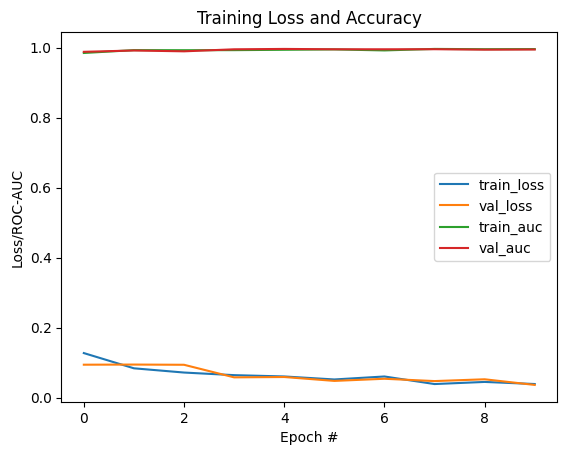

In [ ]:
# vẽ đồ thị thể hiện hàm Loss và hệ số ROC-AUC

N = Epochs
# plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["auc"], label="train_auc")
plt.plot(np.arange(0, N), H.history["val_auc"], label="val_auc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/ROC-AUC")
plt.legend(loc="center right")

**SAMPLE**

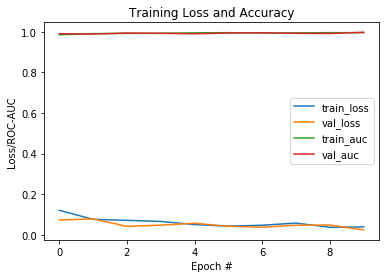

In [ ]:
# vẽ đồ thị thể hiện hàm Loss và hệ số ROC-AUC

# N = Epochs
# plt.style.use("ggplot")
# plt.figure()
# plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
# plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
# plt.plot(np.arange(0, N), H.history["auc"], label="train_auc")
# plt.plot(np.arange(0, N), H.history["val_auc"], label="val_auc")
# plt.title("Training Loss and Accuracy")
# plt.xlabel("Epoch #")
# plt.ylabel("Loss/ROC-AUC")
# plt.legend(loc="center right")

# 5. Kiểm tra mô hình

Nhắc lại, quá trình nhận diện một gương mặt có đeo khẩu trang hay không được thực hiện theo từng bước sau:

**Ảnh chứa gương mặt (1) --> nhận diện gương mặt (2) --> nhận diện có đeo khẩu trăng hoặc không (3) --> Gán nhãn tương ứng (4)**

Trong phần này chúng ta sẽ thực hiện việc kiểm tra mô hình nhận diện đeo khẩu trang. Về phần nhận diện gương mặt chúng ta sẽ sử dụng mô hình MTCNN với các hàm và thư viện mà chúng ta đã cung cấp sẵn

- Import các thư viện cần thiết cho việc kiểm tra

In [ ]:
import sys

sys.path.append("/content/drive/MyDrive/Data Sciene Funix/306/Assignment/ASM1/")

In [50]:
import os
os.chdir('/content/drive/MyDrive/Data Sciene Funix/306/Assignment/ASM1')

In [51]:
import cv2
from align_faces import warp_and_crop_face, get_reference_facial_points
from mtcnn.detector import MtcnnDetector
from tensorflow.keras.models import load_model

- Sử dụng hàm nhận diện gương mặt có sẵn đã được cung cấp để tiến hành Face Detection và Face Alignment trước khi nhận diện khẩu trang.

**Lưu ý**: Hàm này có thể không hoạt động được và trả về lỗi nếu trong bức ảnh không có gương mặt nào hoặc trong một vài trường hợp không thể nhận diện được ảnh trong gương mặt

**Có thể học viên sẽ thắc mắc tại sao chúng ta phải sử dụng Face Alignemnt?**

Đúng như tên gọi của nó: Alignment (sự căn chỉnh), Face Alignment giúp khuôn mặt dù có bị quay ngang, bị chéo mặt hay thậm chị bị mất nhiều chi tiết do điều kiện ngoại cảnh, lệch ra khỏi khung hình... cũng có thể "căn chỉnh" lại về trung tâm bức ảnh với hướng mặt thẳng chính giữa như mong muốn được. Sau bước detection thì các khuôn mặt của chúng ta có thể ở các trạng thái khác nhau hoặc các góc độ khác nhau, có những khuôn mặt bị chéo và cũng có thể bị lệch do bước detect chưa chính xác trong việc lấy ra khung hình chuẩn của mặt. Thì việc áp dụng Face Alignment ở đây là cần thiết, nó có thể hiểu như một hình thức của data normalization (chuẩn hóa dữ liệu), giúp tiêu chuẩn hoá lại dữ liệu trước khi đưa vào mô hình phân loại (binary classcification), điều này giúp cho mô hình có kết quả dự đoán chính xác hơn. Học viên có thể so sánh với **mô hình chỉ có Face Detection mà không có Face Alignment** với mô hình ở phía dưới để so sánh kết quả xem liệu sự có mặt của Face Alignment liệu thật sự có cải thiện kết quả hay không.

**SAMPLE**

In [ ]:
detector = MtcnnDetector()

def face_detection(img, output_size, align = False):
    """Nếu align == True thì sẽ có thêm bước Face Alignment sau khi nhận diện gương mặt,
        ngược lại thì không có thêm bước này"""

    # Nhận diện gương mặt
    boxes, facial5points = detector.detect_faces(img)

    # Tiến hành Alignment
    if align == True:
        if len(facial5points) != 0:
            facial5points = np.reshape(facial5points[0], (2, 5))

            default_square = True
            inner_padding_factor = 0.25
            outer_padding = (0, 0)

            ## Yêu cầu 10:
            ## VIẾT CODE Ở ĐÂY:

            # sử dụng hàm get_reference_facial_points
            reference_5pts = ...(
                output_size, inner_padding_factor, outer_padding, default_square)

            # sử dụng hàm warp_and_crop_face
            face = ...(img, facial5points, reference_pts = reference_5pts, crop_size = output_size)

    # Không Alignment
    else:
        (h,w) = img.shape[:2]
        if len(boxes) != 0:
            for box in boxes:
                (startX, startY, endX, endY) = box[:4].astype('int')
                (startX, startY) = (max(0, startX),max(0, startY))
                (endX, endY) = (min(w-1, endX), min(h-1, endY))
                face = img[startY:endY, startX:endX]
                face = cv2.resize(face, output_size)

    return face

**SOLUTION**

In [ ]:
detector = MtcnnDetector()

def face_detection(img, output_size, align = False):
    """Nếu align == True thì sẽ có thêm bước Face Alignment sau khi nhận diện gương mặt,
        ngược lại thì không có thêm bước này"""

    # Nhận diện gương mặt
    boxes, facial5points = detector.detect_faces(img)

    # Tiến hành Alignment
    if align == True:
        if len(facial5points) != 0:
            facial5points = np.reshape(facial5points[0], (2, 5))

            default_square = True
            inner_padding_factor = 0.3
            outer_padding = (1, 1)

            ## Yêu cầu 10:
            ## VIẾT CODE Ở ĐÂY:

            # sử dụng hàm get_reference_facial_points
            reference_5pts = get_reference_facial_points(
                output_size, inner_padding_factor, outer_padding, default_square)

            # sử dụng hàm warp_and_crop_face
            face = warp_and_crop_face(img, facial5points, reference_pts = reference_5pts, crop_size = output_size)

    # Không Alignment
    else:
        (h,w) = img.shape[:2]
        if len(boxes) != 0:
            for box in boxes:
                (startX, startY, endX, endY) = box[:4].astype('int')
                (startX, startY) = (max(0, startX),max(0, startY))
                (endX, endY) = (min(w-1, endX), min(h-1, endY))
                face = img[startY:endY, startX:endX]
                face = cv2.resize(face, output_size)

    return face

- Tạo ra mảng chứa các ảnh sau đã thực hiện việc nhận diện gương mặt

In [ ]:
test_X_align = test_X.copy()

- Như đã lưu ý ở trên, có thể có một vài bức ảnh không thể nhận diện gương mặt được với hàm này, cho nên chúng ta sẽ chỉ lựa chọn ra các bức ảnh chỉ nhận diện được và lưu chỉ mục của chúng vào mảng **choose**. Sử dụng cấu trúc **try-except** để xử lý lỗi trong trường hợp này

**SAMPLE**

In [ ]:
choose = []

for i in range(len(test_X)):
    try:
        # Tiến hành nhận diện gương mặt kết hợp với Face Alignement, trả về kích thươc ảnh là 224x224
        ## Yêu cầu 11:
        ## VIẾT CODE Ở ĐÂY:
        test_X_align[i] = ...(test_X[i].astype('uint8'), (..., ...), align = ...)
        # Lưu chỉ mục của ảnh đã nhận diện thành công vào mảng choose
        choose.append(...)
    ...:
        # Nếu tấm ảnh không nhận diện được thì chúng ta sẽ bỏ qua tấm này
        continue

choose = np.array(choose)

**SOLUTION**

In [ ]:
choose = []

for i in range(len(test_X)):
    try:
        # Tiến hành nhận diện gương mặt kết hợp với Face Alignement, trả về kích thươc ảnh là 224x224
        ## Yêu cầu 11:
        ## VIẾT CODE Ở ĐÂY:
        test_X_align[i] = face_detection(test_X[i].astype('uint8'), (224, 224), align = True)
        # Lưu chỉ mục của ảnh đã nhận diện thành công vào mảng choose
        choose.append(i)
    except:
        # Nếu tấm ảnh không nhận diện được thì chúng ta sẽ bỏ qua tấm này
        continue

choose = np.array(choose)

In [ ]:
test_X_align.shape

(2160, 224, 224, 3)

In [ ]:
test_X_align[choose, :, :, :].shape

(1170, 224, 224, 3)

In [ ]:
len(choose)

1170

**SAMPLE**

In [ ]:
# test_X_align.shape

(3200, 224, 224, 3)

In [ ]:
# test_X_align[choose, :, :, :].shape

(3097, 224, 224, 3)

- Chúng ta sẽ sử dụng chỉ số **ROC-AUC** làm chỉ số đánh giá mô hình

In [23]:
from sklearn.metrics import roc_auc_score

- Lọc ra các tấm ảnh với mảng choose và tiến hành tính chỉ số ROC-AUC

In [ ]:
predict = model.predict(test_X_align[choose])
predict = np.argmax(predict, axis = 1)
roc_auc_score(test_Y[choose].argmax(axis = 1), predict)

37/37 [==============================] - 17s 331ms/step


0.9780300566596892

**SAMPLE**

In [ ]:
## Yêu cầu 12:
## VIẾT CODE Ở ĐÂY:
predict = model....(test_X_align[...])
predict = np.argmax(..., axis = ...)
roc_auc_score(test_Y[...]....(axis = ...), ...)

0.9903089374314709

## 5.1 Multi-faces

Nếu ở phần trên chúng ta chỉ nhận diện tấm ảnh chỉ có một gương mặt duy nhất thì ở phần này chúng ta sẽ nhận diện nhiều gương mặt có đeo khẩu trang hay không trong cùng một bức ảnh với mô hình ở trên

- Sử dụng hàm có sẵn

In [ ]:
def mask_detect(image):

    img = image.copy()
    (h,w) = img.shape[:2]
    boxes, facial5points = detector.detect_faces(img)
    for box in boxes:
        (startX,startY,endX,endY)=box[:4].astype('int')

        #ensure the bounding boxes fall within the dimensions of the frame
        (startX,startY)=(max(0,startX),max(0,startY))
        (endX,endY)=(min(w-1,endX), min(h-1,endY))


        #extract the face ROI, convert it from BGR to RGB channel, resize it to 224,224 and preprocess it
        face=img[startY:endY, startX:endX]
        face=cv2.resize(face,(224,224))

        (mask,withoutMask)=model.predict(face.reshape(1,224,224,3))[0]

        #determine the class label and color we will use to draw the bounding box and text
        label='Mask' if mask>withoutMask else 'No Mask'
        color=(0,255,0) if label=='Mask' else (0,0,255)

        #include the probability in the label
        label="{}: {:.2f}%".format(label,max(mask,withoutMask)*100)

        #display the label and bounding boxes
        cv2.putText(img,label,(startX,startY-10),cv2.FONT_HERSHEY_SIMPLEX,0.45,color,2)
        cv2.rectangle(img,(startX,startY),(endX,endY),color,2)

    return img

- Nhận diện một vài bức ảnh có sẵn trong thư mục image

In [ ]:
from google.colab.patches import cv2_imshow

1/1 [==============================] - 2s 2s/step


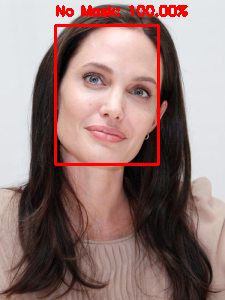

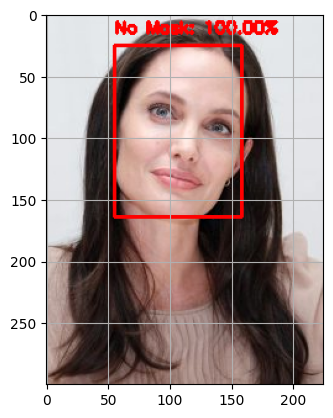

In [ ]:
img = cv2.imread("image/angelina.jpg")
## Yêu cầu 13:
## VIẾT CODE Ở ĐÂY:
img = mask_detect(img)

plt.imshow(img[:, :, ::-1])
plt.grid(None)

cv2_imshow(img)
cv2.waitKey(0)
cv2.destroyAllWindows()

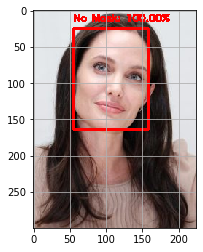

In [ ]:
img = cv2.imread("image/angelina.jpg")
## Yêu cầu 13:
## VIẾT CODE Ở ĐÂY:
img = ...(img)

plt.imshow(img[:, :, ::-1])
plt.grid(None)

cv2.imshow("OutPut",img)
cv2.waitKey(0)
cv2.destroyAllWindows()

1/1 [==============================] - 0s 22ms/step


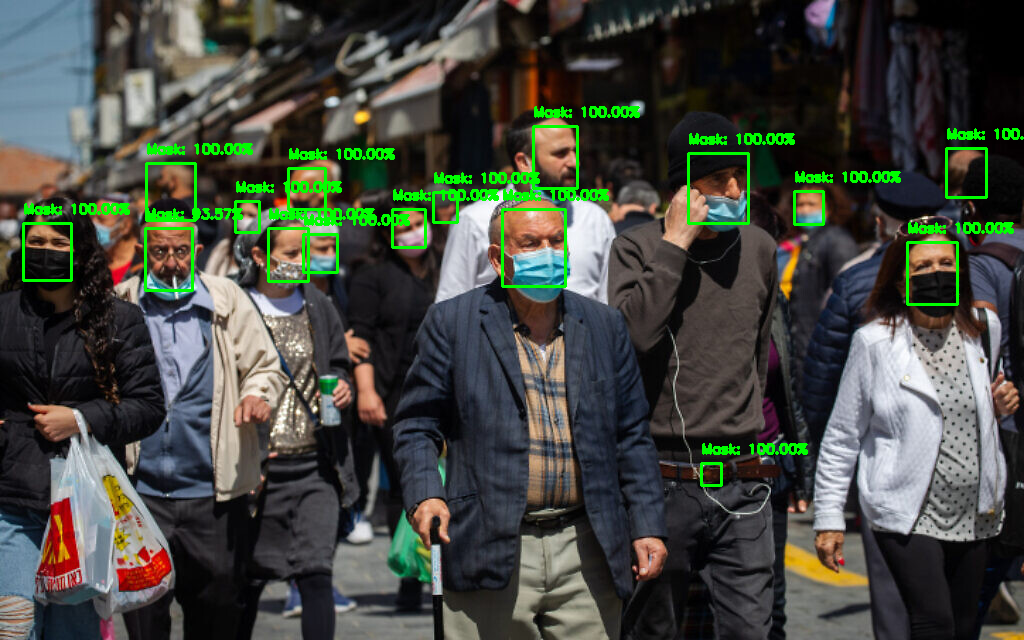

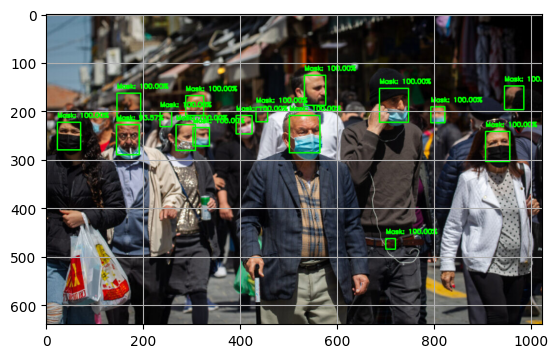

In [ ]:
img = cv2.imread("image/people.jpg")
## Yêu cầu 14:
## VIẾT CODE Ở ĐÂY:
img = mask_detect(img)

plt.imshow(img[:, :, ::-1])
plt.grid(None)

cv2_imshow(img)
cv2.waitKey(0)
cv2.destroyAllWindows()

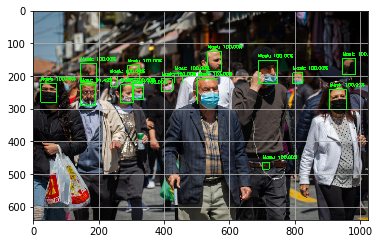

In [ ]:
img = cv2.imread("image/people.jpg")
## Yêu cầu 14:
## VIẾT CODE Ở ĐÂY:
img = ...(img)

plt.imshow(img[:, :, ::-1])
plt.grid(None)

cv2.imshow("OutPut",img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
img = cv2.imread("image/woman.jpg")
## Yêu cầu 15:
## VIẾT CODE Ở ĐÂY:
img = mask_detect(img)

plt.imshow(img[:, :, ::-1])
plt.grid(None)

cv2_imshow(img)
cv2.waitKey(0)
cv2.destroyAllWindows()

Output hidden; open in https://colab.research.google.com to view.

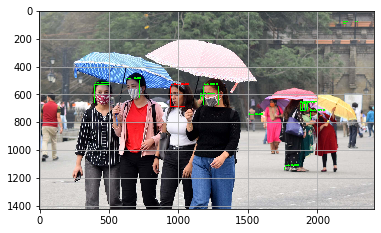

In [ ]:
img = cv2.imread("image/woman.jpg")
## Yêu cầu 15:
## VIẾT CODE Ở ĐÂY:
img = ...(img)

plt.imshow(img[:, :, ::-1])
plt.grid(None)

cv2.imshow("OutPut",img)
cv2.waitKey(0)
cv2.destroyAllWindows()

1/1 [==============================] - 0s 24ms/step


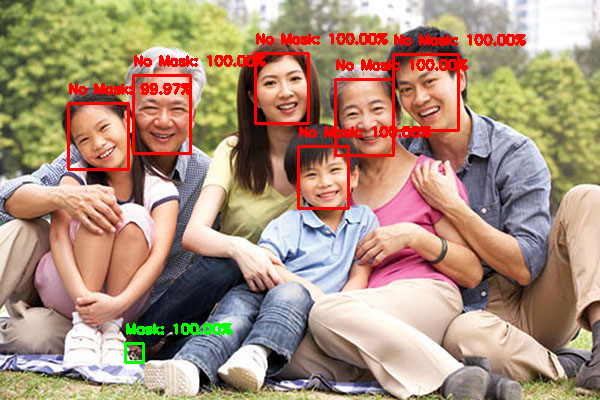

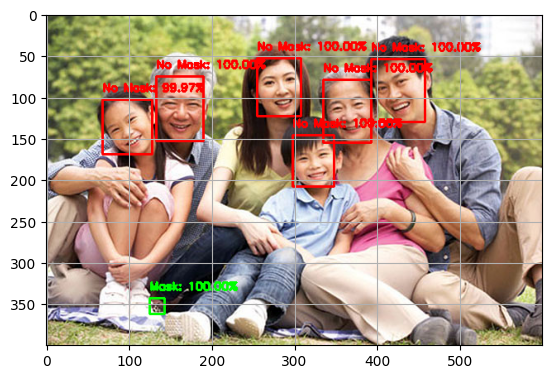

In [ ]:
img = cv2.imread("image/family.jpg")
## Yêu cầu 16:
## VIẾT CODE Ở ĐÂY:
img = mask_detect(img)

plt.imshow(img[:, :, ::-1])
plt.grid(None)

cv2_imshow(img)
cv2.waitKey(0)
cv2.destroyAllWindows()

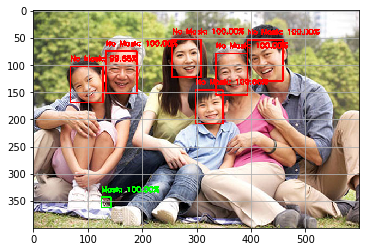

In [ ]:
img = cv2.imread("image/family.jpg")
## Yêu cầu 16:
## VIẾT CODE Ở ĐÂY:
img = ...(img)

plt.imshow(img[:, :, ::-1])
plt.grid(None)

cv2.imshow("OutPut",img)
cv2.waitKey(0)
cv2.destroyAllWindows()

## 5.2 Video

Ở phần này chúng ta sẽ nhận diện gương mặt đeo khẩu trang theo thời gian thực thông qua camera của máy tính

In [ ]:
from imutils.video import VideoStream
import imutils

In [ ]:
vs = cv2.VideoCapture("/content/drive/MyDrive/Data Sciene Funix/306/Assignment/ASM1/Movie on 10-4-24 at 14.50.mov")

while True:
    #grab the frame from the threaded video stream and resize it
    #to have a maximum width of 400 pixels
    frame = vs.read()[1]
    (h, w) = frame.shape[:2]
    boxes, facial5points = detector.detect_faces(frame)
    for box in boxes:
        (startX, startY, endX, endY) = box[:4].astype('int')

        #ensure the bounding boxes fall within the dimensions of the frame
        (startX, startY) = (max(0, startX),max(0, startY))
        (endX, endY) = (min(w-1, endX), min(h-1, endY))


        #extract the face ROI, convert it from BGR to RGB channel, resize it to 224,224 and preprocess it
        face = frame[startY:endY, startX:endX]
        face = cv2.resize(face,(224,224))

        (mask, withoutMask) = model.predict(face.reshape(1,224,224,3))[0]

        #determine the class label and color we will use to draw the bounding box and text
        label = 'Mask' if mask > withoutMask else 'No Mask'
        color = (0, 255, 0) if label == 'Mask' else (0, 0, 255)

        #include the probability in the label
        label = "{}: {:.2f}%".format(label, max(mask, withoutMask)*100)

        #display the label and bounding boxes
        cv2.putText(frame, label, (startX, startY-10), cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
        cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)

    #show the output frame
    cv2_imshow(frame)
    key = cv2.waitKey(1) & 0xFF

    if key == ord('q'):
        break
cv2.destroyAllWindows()

Output hidden; open in https://colab.research.google.com to view.

# 6. Cải thiện mô hình

- Phần này học viên sẽ tự đề xuất và thực thi các phương pháp khác nhau nhằm mục đích cải thiện chất lượng mô hình tốt hơn có thể có. Tức là chỉ số **ROC-AUC >= 0.992**. Một số phương pháp được đề xuất như sau:

1. Cải thiện model nhận diện đeo khẩu trang.

2. Cải thiện model phát hiện khuôn mặt.

3. Sử dụng thêm dữ liệu cho quá trình huấn luyện.

4. Cải thiện phần face alignment

In [24]:
## Yêu cầu 17:
## VIẾT CODE Ở ĐÂY:
len(imagePaths)

17819

**Get more data**

In [25]:
# khởi tạo list rỗng: chứa các bức ảnh
data = []

# khởi tạo list rỗng: chứa các nhãn của bức ảnh
# (cũng chính là tiêu đề của thư mục chứa các bức ảnh: with/without mask)
labels = []

for i in imagePaths[-6000:] + imagePaths[:6000]:

    label = i.split(os.path.sep)[-2]
    # Chèn các dữ liệu nhãn vào list labels
    labels.append(label)

    # Sử dụng hàm load_img để tạo mảng chứ dữ liệu tấm ảnh với kích thước 224 x 224
    image = load_img(i, target_size = (224, 224))
    image = img_to_array(image)
    # Chèn các dữ liệu ảnh vào list data
    data.append(image)

# mã hóa list dữ liệu thành định dạng mảng NumPy
data = np.array(data,dtype='float32')
labels = np.array(labels)

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [26]:
data.shape

(12000, 224, 224, 3)

In [27]:
labels.shape

(12000,)

In [28]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

# Chuyển từng nhãn thành vector nhị phân tương ứng
labels = to_categorical(labels)

In [29]:
labels.shape

(12000, 2)

In [30]:
train_X, test_X, train_Y, test_Y = train_test_split(data, labels, test_size = 0.3, stratify = labels, random_state = 0)
val_X, test_X, val_Y, test_Y = train_test_split(test_X, test_Y, test_size = 0.6, stratify = test_Y, random_state = 0)

print("train_X shape: ", train_X.shape)
print("train_Y shape: ", train_Y.shape)
print("\n")
print("val_X shape: ", val_X.shape)
print("val_Y shape: ", val_Y.shape)
print("\n")
print("test_X shape: ", test_X.shape)
print("test_Y shape: ", test_Y.shape)

train_X shape:  (8400, 224, 224, 3)
train_Y shape:  (8400, 2)


val_X shape:  (1440, 224, 224, 3)
val_Y shape:  (1440, 2)


test_X shape:  (2160, 224, 224, 3)
test_Y shape:  (2160, 2)


In [31]:
from tensorflow.keras.applications import EfficientNetV2B3

In [32]:
baseModel = EfficientNetV2B3(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

52606240/52606240 [==============================] - 2s 0us/step


In [33]:
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization, Activation
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2

In [34]:
headModel = baseModel.output
headModel = GlobalAveragePooling2D()(headModel)
headModel = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(headModel)  # Added L2 regularization
headModel = BatchNormalization()(headModel)
headModel = Dropout(0.5)(headModel)  # Increased dropout rate
headModel = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(headModel)  # Added L2 regularization
headModel = BatchNormalization()(headModel)
headModel = Dropout(0.5)(headModel)  # Increased dropout rate
headModel = Dense(2)(headModel)
headModel = Activation('softmax', dtype = tf.float32)(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

In [35]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          0         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 stem_conv (Conv2D)          (None, 112, 112, 40)         1080      ['normalization[0][0]']   

In [36]:
for layer in baseModel.layers:
    layer.trainable = False

In [37]:
for layer in model.layers:
  print(layer.name, layer.trainable)

input_1 False
rescaling False
normalization False
stem_conv False
stem_bn False
stem_activation False
block1a_project_conv False
block1a_project_bn False
block1a_project_activation False
block1b_project_conv False
block1b_project_bn False
block1b_project_activation False
block1b_drop False
block1b_add False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_project_conv False
block2a_project_bn False
block2b_expand_conv False
block2b_expand_bn False
block2b_expand_activation False
block2b_project_conv False
block2b_project_bn False
block2b_drop False
block2b_add False
block2c_expand_conv False
block2c_expand_bn False
block2c_expand_activation False
block2c_project_conv False
block2c_project_bn False
block2c_drop False
block2c_add False
block3a_expand_conv False
block3a_expand_bn False
block3a_expand_activation False
block3a_project_conv False
block3a_project_bn False
block3b_expand_conv False
block3b_expand_bn False
block3b_expand_activation False

In [38]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001, verbose=1)

In [39]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

In [40]:
checkpoint_path = "/content/drive/MyDrive/Data Sciene Funix/306/Assignment/ASM1/final_checkpoint/checkpoints.ckpt"
model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss',save_weights_only=True, save_best_only=True, verbose=1)

In [41]:
learning_rate = 0.0005
Epochs = 10
BS = 32
decay = learning_rate/Epochs

# Khởi tạo thuật toán tối ưu Adam
## Yêu cầu 9:
## VIẾT CODE Ở ĐÂY:
opt = Adam(learning_rate = learning_rate, weight_decay = decay)
model.compile(loss="binary_crossentropy", optimizer = opt, metrics = [tf.keras.metrics.AUC()])

H = model.fit(
    # tiến hành tăng cường dữ liệu
    aug.flow(train_X, train_Y, batch_size = BS),
    steps_per_epoch = len(train_X)//BS,
    validation_data = (val_X, val_Y),
    validation_steps = len(val_X)//BS,
    epochs = Epochs,
    callbacks = [early_stopping, model_checkpoint]
)

# lưu mô hình lại để tiện cho việc tái sử dụng sau này, lưu trữ dưới tên 'efficientnet.model'
model.save('efficientnet_version2.model')

Epoch 1/10
262/262 [==============================] - ETA: 0s - loss: 2.7750 - auc: 0.9775
Epoch 1: val_loss improved from inf to 1.67453, saving model to /content/drive/MyDrive/Data Sciene Funix/306/Assignment/ASM1/final_checkpoint/checkpoints.ckpt
262/262 [==============================] - 108s 336ms/step - loss: 2.7750 - auc: 0.9775 - val_loss: 1.6745 - val_auc: 0.9973
Epoch 2/10
262/262 [==============================] - ETA: 0s - loss: 1.2099 - auc: 0.9854
Epoch 2: val_loss improved from 1.67453 to 0.74806, saving model to /content/drive/MyDrive/Data Sciene Funix/306/Assignment/ASM1/final_checkpoint/checkpoints.ckpt
262/262 [==============================] - 85s 324ms/step - loss: 1.2099 - auc: 0.9854 - val_loss: 0.7481 - val_auc: 0.9970
Epoch 3/10
262/262 [==============================] - ETA: 0s - loss: 0.6259 - auc: 0.9868
Epoch 3: val_loss improved from 0.74806 to 0.40924, saving model to /content/drive/MyDrive/Data Sciene Funix/306/Assignment/ASM1/final_checkpoint/checkpoint

In [65]:
headModel = baseModel.output
headModel = GlobalAveragePooling2D()(headModel)
headModel = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(headModel)  # Added L2 regularization
headModel = BatchNormalization()(headModel)
headModel = Dropout(0.5)(headModel)  # Increased dropout rate
headModel = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(headModel)  # Added L2 regularization
headModel = BatchNormalization()(headModel)
headModel = Dropout(0.5)(headModel)  # Increased dropout rate
headModel = Dense(2)(headModel)
headModel = Activation('softmax', dtype = tf.float32)(headModel)

mymodel = Model(inputs=baseModel.input, outputs=headModel)

In [66]:
mymodel.load_weights(checkpoint_path2)

In [67]:
baseModel.trainable = True

for layer in baseModel.layers[:-50]:
    layer.trainable = False

In [68]:
learning_rate = 0.00001
FinalEpochs = 30
BS = 32
decay = learning_rate/Epochs

opt = Adam(learning_rate = learning_rate, weight_decay = decay)
mymodel.compile(loss="binary_crossentropy", optimizer = opt, metrics = [tf.keras.metrics.AUC()])

In [46]:
checkpoint_path2 = "/content/drive/MyDrive/Data Sciene Funix/306/Assignment/ASM1/final_checkpoint/checkpoints2.ckpt"
model_checkpoint2 = ModelCheckpoint(checkpoint_path2, monitor='val_loss', save_best_only=True, verbose=1)

In [69]:
checkpoint_path3 = "/content/drive/MyDrive/Data Sciene Funix/306/Assignment/ASM1/final_checkpoint/checkpoints3.ckpt"
model_checkpoint3 = ModelCheckpoint(checkpoint_path3, monitor='val_loss', save_best_only=True, verbose=1)

In [70]:
H_final_2 = mymodel.fit(
    aug.flow(train_X, train_Y, batch_size = BS),
    steps_per_epoch = len(train_X)//BS,
    validation_data = (val_X, val_Y),
    validation_steps = len(val_X)//BS,
    epochs = FinalEpochs,
    initial_epoch=H_final.epoch[-1],
    callbacks = [reduce_lr, early_stopping, model_checkpoint3]
)

Epoch 20/30
262/262 [==============================] - ETA: 0s - loss: 0.2001 - auc_3: 0.9902
Epoch 20: val_loss improved from inf to 0.09132, saving model to /content/drive/MyDrive/Data Sciene Funix/306/Assignment/ASM1/final_checkpoint/checkpoints3.ckpt
262/262 [==============================] - 146s 473ms/step - loss: 0.2001 - auc_3: 0.9902 - val_loss: 0.0913 - val_auc_3: 0.9978 - lr: 5.0000e-04
Epoch 21/30
262/262 [==============================] - ETA: 0s - loss: 0.1081 - auc_3: 0.9954
Epoch 21: val_loss improved from 0.09132 to 0.08886, saving model to /content/drive/MyDrive/Data Sciene Funix/306/Assignment/ASM1/final_checkpoint/checkpoints3.ckpt
262/262 [==============================] - 124s 473ms/step - loss: 0.1081 - auc_3: 0.9954 - val_loss: 0.0889 - val_auc_3: 0.9965 - lr: 5.0000e-04
Epoch 22/30
262/262 [==============================] - ETA: 0s - loss: 0.0898 - auc_3: 0.9956
Epoch 22: val_loss improved from 0.08886 to 0.06620, saving model to /content/drive/MyDrive/Data Sci

In [52]:
detector = MtcnnDetector()

def face_detection(img, output_size, align = False):
    """Nếu align == True thì sẽ có thêm bước Face Alignment sau khi nhận diện gương mặt,
        ngược lại thì không có thêm bước này"""

    # Nhận diện gương mặt
    boxes, facial5points = detector.detect_faces(img)

    # Tiến hành Alignment
    if align == True:
        if len(facial5points) != 0:
            facial5points = np.reshape(facial5points[0], (2, 5))

            default_square = True
            inner_padding_factor = 0.3
            outer_padding = (0.3, 0.3)

            ## Yêu cầu 10:
            ## VIẾT CODE Ở ĐÂY:

            # sử dụng hàm get_reference_facial_points
            reference_5pts = get_reference_facial_points(
                output_size, inner_padding_factor, outer_padding, default_square)

            # sử dụng hàm warp_and_crop_face
            face = warp_and_crop_face(img, facial5points, reference_pts = reference_5pts, crop_size = output_size)

    # Không Alignment
    else:
        (h,w) = img.shape[:2]
        if len(boxes) != 0:
            for box in boxes:
                (startX, startY, endX, endY) = box[:4].astype('int')
                (startX, startY) = (max(0, startX),max(0, startY))
                (endX, endY) = (min(w-1, endX), min(h-1, endY))
                face = img[startY:endY, startX:endX]
                face = cv2.resize(face, output_size)

    return face

In [53]:
test_X_align = test_X.copy()

In [54]:
choose = []

for i in range(len(test_X)):
    try:
        # Tiến hành nhận diện gương mặt kết hợp với Face Alignement, trả về kích thươc ảnh là 224x224
        ## Yêu cầu 11:
        ## VIẾT CODE Ở ĐÂY:
        test_X_align[i] = face_detection(test_X[i].astype('uint8'), (224, 224), align = True)
        # Lưu chỉ mục của ảnh đã nhận diện thành công vào mảng choose
        choose.append(i)
    except:
        # Nếu tấm ảnh không nhận diện được thì chúng ta sẽ bỏ qua tấm này
        continue

choose = np.array(choose)

In [55]:
len(choose)

1170

In [71]:
predict = mymodel.predict(test_X_align[choose])
predict = np.argmax(predict, axis = 1)
roc_auc_score(test_Y[choose].argmax(axis = 1), predict)

37/37 [==============================] - 4s 22ms/step


0.9780071546026264